In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
import time
import pandas as pd
import seaborn as sn
import keras
import os
import cv2
import pickle
import random
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib
# matplotlib.use("Agg")

Using TensorFlow backend.


In [2]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 300
INIT_LR = 1e-2
BS = 32
IMAGE_DIMS = (224, 224, 3)

In [3]:
from imutils import paths

imagePaths = sorted(list(paths.list_images("both_classification_minority_duplicated")))
random.seed(42)
random.shuffle(imagePaths)
imagePaths

['both_classification_minority_duplicated\\non_both\\non_both_1906.jpg',
 'both_classification_minority_duplicated\\non_both\\non_both_253.jpg',
 'both_classification_minority_duplicated\\non_both\\non_both_501.jpg',
 'both_classification_minority_duplicated\\both\\both_154 - Copy (13).jpg',
 'both_classification_minority_duplicated\\both\\both_44 - Copy (4).jpg',
 'both_classification_minority_duplicated\\non_both\\non_both_1165.jpg',
 'both_classification_minority_duplicated\\both\\both_26 - Copy (5).jpg',
 'both_classification_minority_duplicated\\non_both\\non_both_2164.jpg',
 'both_classification_minority_duplicated\\both\\both_81 - Copy (11).jpg',
 'both_classification_minority_duplicated\\both\\both_72 - Copy (2).jpg',
 'both_classification_minority_duplicated\\both\\both_54 - Copy (8).jpg',
 'both_classification_minority_duplicated\\non_both\\non_both_1745.jpg',
 'both_classification_minority_duplicated\\both\\both_122 - Copy (5).jpg',
 'both_classification_minority_duplicated\

In [4]:
from keras.preprocessing.image import img_to_array

data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [5]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 6646.75MB


In [6]:
from sklearn.preprocessing import LabelBinarizer

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [7]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

In [8]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [9]:
from keras.optimizers import SGD

print("[INFO] compiling model...")
from keras.applications import ResNet50
model = ResNet50()

opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR/EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] done compiling.")

model.summary()

[INFO] compiling model...
[INFO] done compiling.
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________

In [10]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [11]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)#, class_weight={0:3, 1:1})

# save the model to disk
print("[INFO] serializing network...")
model.save("both_minority_duplicated_resnet50_300_epochs.model")

[INFO] training network...
Epoch 1/300
141/141 [==============================] - 72s 511ms/step - loss: 0.7477 - accuracy: 0.7122 - val_loss: 1.5943 - val_accuracy: 0.4969
Epoch 2/300
141/141 [==============================] - 59s 420ms/step - loss: 0.3820 - accuracy: 0.8334 - val_loss: 1.9152 - val_accuracy: 0.4969
Epoch 3/300
141/141 [==============================] - 59s 420ms/step - loss: 0.2800 - accuracy: 0.8900 - val_loss: 1.0504 - val_accuracy: 0.4969
Epoch 4/300
141/141 [==============================] - 59s 419ms/step - loss: 0.2518 - accuracy: 0.9024 - val_loss: 0.8558 - val_accuracy: 0.4943
Epoch 5/300
141/141 [==============================] - 59s 420ms/step - loss: 0.2136 - accuracy: 0.9209 - val_loss: 0.9694 - val_accuracy: 0.6172
Epoch 6/300
141/141 [==============================] - 59s 420ms/step - loss: 0.2063 - accuracy: 0.9231 - val_loss: 0.8203 - val_accuracy: 0.7763
Epoch 7/300
141/141 [==============================] - 59s 420ms/step - loss: 0.1951 - accuracy: 

141/141 [==============================] - 59s 417ms/step - loss: 0.0957 - accuracy: 0.9673 - val_loss: 0.1508 - val_accuracy: 0.9549
Epoch 57/300
141/141 [==============================] - 59s 417ms/step - loss: 0.1055 - accuracy: 0.9637 - val_loss: 0.1417 - val_accuracy: 0.9602
Epoch 58/300
141/141 [==============================] - 59s 419ms/step - loss: 0.0954 - accuracy: 0.9676 - val_loss: 0.1647 - val_accuracy: 0.9478
Epoch 59/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0984 - accuracy: 0.9666 - val_loss: 0.1284 - val_accuracy: 0.9602
Epoch 60/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0906 - accuracy: 0.9690 - val_loss: 0.1470 - val_accuracy: 0.9558
Epoch 61/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0994 - accuracy: 0.9664 - val_loss: 0.1414 - val_accuracy: 0.9576
Epoch 62/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0947 - accuracy: 0.9693 - val_loss: 0.1296 - val_a

Epoch 112/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0797 - accuracy: 0.9739 - val_loss: 0.1348 - val_accuracy: 0.9584
Epoch 113/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0800 - accuracy: 0.9739 - val_loss: 0.1185 - val_accuracy: 0.9682
Epoch 114/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0777 - accuracy: 0.9757 - val_loss: 0.1257 - val_accuracy: 0.9620
Epoch 115/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0841 - accuracy: 0.9733 - val_loss: 0.1263 - val_accuracy: 0.9699
Epoch 116/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0809 - accuracy: 0.9746 - val_loss: 0.1272 - val_accuracy: 0.9708
Epoch 117/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0756 - accuracy: 0.9759 - val_loss: 0.1172 - val_accuracy: 0.9699
Epoch 118/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0805 - accuracy: 0.9744 - val_

141/141 [==============================] - 59s 418ms/step - loss: 0.0756 - accuracy: 0.9755 - val_loss: 0.1555 - val_accuracy: 0.9655
Epoch 168/300
141/141 [==============================] - 59s 419ms/step - loss: 0.0778 - accuracy: 0.9743 - val_loss: 0.1227 - val_accuracy: 0.9708
Epoch 169/300
141/141 [==============================] - 59s 416ms/step - loss: 0.0715 - accuracy: 0.9785 - val_loss: 0.1064 - val_accuracy: 0.9744
Epoch 170/300
141/141 [==============================] - 59s 419ms/step - loss: 0.0762 - accuracy: 0.9770 - val_loss: 0.1209 - val_accuracy: 0.9717
Epoch 171/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0758 - accuracy: 0.9757 - val_loss: 0.1177 - val_accuracy: 0.9717
Epoch 172/300
141/141 [==============================] - 59s 415ms/step - loss: 0.0688 - accuracy: 0.9781 - val_loss: 0.1232 - val_accuracy: 0.9682
Epoch 173/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0815 - accuracy: 0.9735 - val_loss: 0.1201 -

141/141 [==============================] - 59s 415ms/step - loss: 0.0723 - accuracy: 0.9774 - val_loss: 0.1369 - val_accuracy: 0.9752
Epoch 223/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0666 - accuracy: 0.9779 - val_loss: 0.1441 - val_accuracy: 0.9744
Epoch 224/300
141/141 [==============================] - 59s 419ms/step - loss: 0.0700 - accuracy: 0.9772 - val_loss: 0.1399 - val_accuracy: 0.9744
Epoch 225/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0688 - accuracy: 0.9777 - val_loss: 0.1402 - val_accuracy: 0.9744
Epoch 226/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0702 - accuracy: 0.9775 - val_loss: 0.1381 - val_accuracy: 0.9744
Epoch 227/300
141/141 [==============================] - 59s 415ms/step - loss: 0.0715 - accuracy: 0.9772 - val_loss: 0.1463 - val_accuracy: 0.9673
Epoch 228/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0665 - accuracy: 0.9793 - val_loss: 0.1625 -

141/141 [==============================] - 59s 417ms/step - loss: 0.0707 - accuracy: 0.9773 - val_loss: 0.1439 - val_accuracy: 0.9735
Epoch 278/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0702 - accuracy: 0.9773 - val_loss: 0.1496 - val_accuracy: 0.9726
Epoch 279/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0664 - accuracy: 0.9784 - val_loss: 0.1477 - val_accuracy: 0.9752
Epoch 280/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0717 - accuracy: 0.9766 - val_loss: 0.1669 - val_accuracy: 0.9655
Epoch 281/300
141/141 [==============================] - 59s 417ms/step - loss: 0.0706 - accuracy: 0.9773 - val_loss: 0.1707 - val_accuracy: 0.9602
Epoch 282/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0692 - accuracy: 0.9775 - val_loss: 0.1599 - val_accuracy: 0.9735
Epoch 283/300
141/141 [==============================] - 59s 418ms/step - loss: 0.0684 - accuracy: 0.9773 - val_loss: 0.1584 -

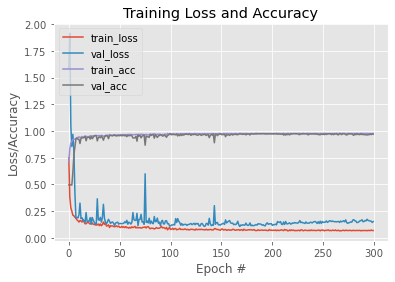

<Figure size 432x288 with 0 Axes>

In [12]:
plt.style.use("ggplot")
%matplotlib inline
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('both_classification_minority_duplicated_resnet50_300_epochs.png', dpi=100)

In [13]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 

# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs, axis=1)

Classification report: 
---------------------------------------------------------- 
              precision    recall  f1-score   support

       anger       0.95      0.99      0.97       569
   non-anger       0.99      0.94      0.97       562

    accuracy                           0.97      1131
   macro avg       0.97      0.97      0.97      1131
weighted avg       0.97      0.97      0.97      1131

---------------------------------------------------------- 
Accuracy score: 0.969938
Precision score: 0.994382
Recall score: 0.944840
F1 score: 0.968978
---------------------------------------------------------- 
Confusion matrix: 
[[566   3]
 [ 31 531]]


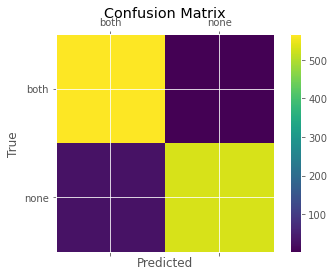

[[566   3]
 [ 31 531]]


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

classif_report = classification_report(testY, yhat_classes, target_names=['anger', 'non-anger'])
print('Classification report: ')
print('---------------------------------------------------------- ')
print(classif_report)

print('---------------------------------------------------------- ')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy score: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision score: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall score: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
print('---------------------------------------------------------- ')

# confusion matrix
labels = ['both', 'none']
matrix = confusion_matrix(testY, yhat_classes)
print('Confusion matrix: ')
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_both_minority_duplicated_resnet50_300_epochs.png')
plt.show()
print(matrix)